In [41]:
import pandas as pd
import numpy as np
import gc
import os,sys
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100

In [42]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [43]:
sell_prices = pd.read_csv('sell_prices.csv')
validation = pd.read_csv('sales_train_validation.csv')
calendar = pd.read_csv('calendar.csv')
sample_submission = pd.read_csv(('sample_submission.csv'))
main = pd.read_csv('main.csv')
#sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))

In [41]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


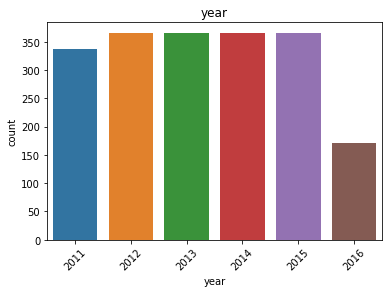

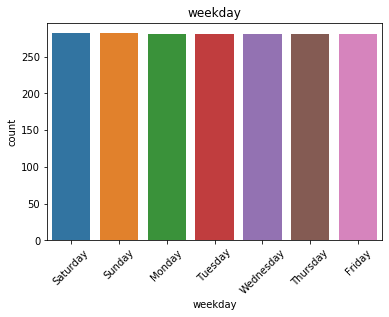

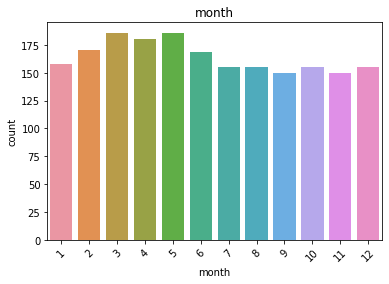

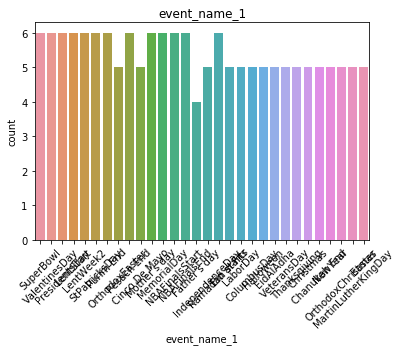

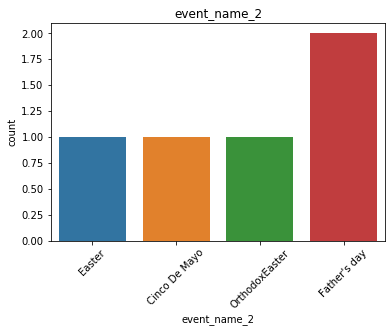

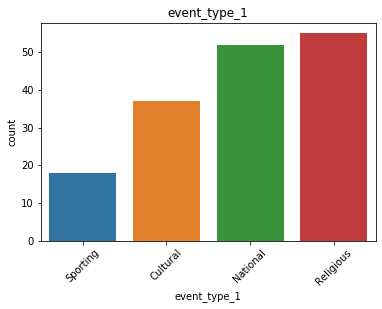

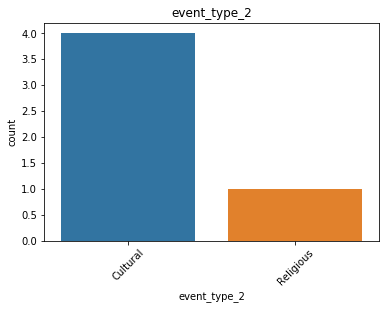

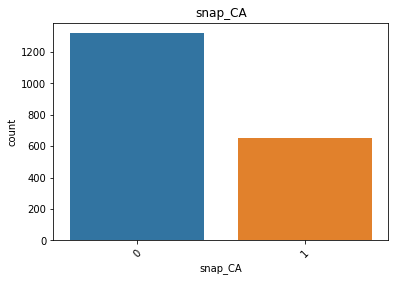

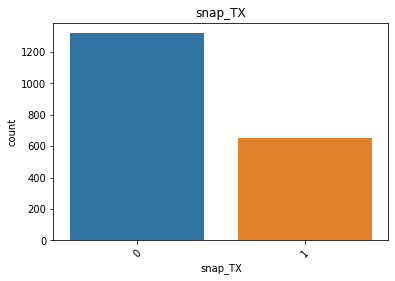

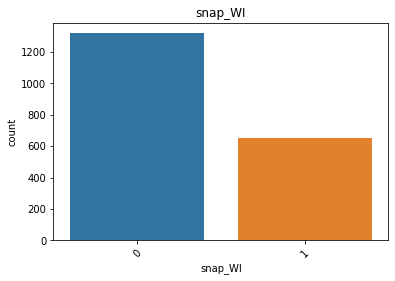

In [29]:
for i, var in enumerate(["year", "weekday", "month", "event_name_1", "event_name_2", 
                         "event_type_1", "event_type_2", "snap_CA", "snap_TX", "snap_WI"]):
    plt.figure()
    g = sns.countplot(calendar[var])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_title(var)

In [24]:
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [42]:
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    df = df.drop(["date", "weekday"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    df = df.fillna("missing")
    cols = list(set(df.columns) - {"wm_yr_wk", "d"})
    df[cols] = OrdinalEncoder(dtype="int").fit_transform(df[cols])
    df = reduce_mem_usage(df)
    return df

calendar = prep_calendar(calendar)

Mem. usage decreased to  0.03 Mb (84.7% reduction)


In [43]:
calendar.head()

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,11101,0,0,0,1,30,4,4,2,0,0,0
1,11101,1,0,0,2,30,4,4,2,0,0,0
2,11101,2,0,0,3,30,4,4,2,0,0,0
3,11101,3,1,0,4,30,4,4,2,1,1,0
4,11101,4,1,0,5,30,4,4,2,1,0,1


In [25]:
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [58]:
def prep_selling_prices(df):
    gr = df.groupby(["store_id", "item_id"])["sell_price"]
    df["sell_price_rel_diff"] = gr.pct_change()
    df["sell_price_roll_sd7"] = gr.transform(lambda x: x.rolling(7).std())
    df["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())
    df = reduce_mem_usage(df)
    return df

sell_prices = prep_selling_prices(sell_prices)

Mem. usage decreased to 169.63 Mb (0.0% reduction)


In [26]:
sell_prices.tail()

,store_id,item_id,wm_yr_wk,sell_price
6841116,WI_3,FOODS_3_827,11617,1.0
6841117,WI_3,FOODS_3_827,11618,1.0
6841118,WI_3,FOODS_3_827,11619,1.0
6841119,WI_3,FOODS_3_827,11620,1.0
6841120,WI_3,FOODS_3_827,11621,1.0


In [60]:
validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,...,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,0,1,4,2,0,2,0,0,0,0,3,1,3,0,2,1,2,0,2,1,2,0,2,2,2,4,2,2,0,2,1,7,1,2,3,0,1,2,3,0,1,5,...,0,0,0,0,1,1,1,1,3,0,0,2,1,2,2,0,2,2,0,1,1,0,2,1,1,0,4,0,0,4,1,3,0,1,0,2,2,0,1,1,0,2,0,4,1,1,0,1,1,0
1,FOODS_1_001_CA_2_validation,FOODS_1_001,FOODS_1,FOODS,CA_2,CA,2,0,0,0,1,0,8,0,4,1,2,1,1,3,4,1,2,2,2,0,1,1,1,1,2,3,16,0,0,0,0,0,1,1,1,1,3,1,0,0,0,1,2,1,...,0,2,0,0,1,1,0,0,4,2,1,0,0,0,2,1,0,0,0,0,2,1,0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,2,0,1,0,14,0,1,1,4,0,0,4
2,FOODS_1_001_CA_3_validation,FOODS_1_001,FOODS_1,FOODS,CA_3,CA,1,2,1,1,1,2,0,1,1,1,0,0,3,3,2,7,1,2,4,0,1,1,3,2,0,0,0,0,6,6,1,1,0,0,4,3,6,5,1,0,3,1,1,1,...,1,0,0,1,0,0,0,0,2,0,0,0,1,2,4,2,0,1,1,1,12,0,0,0,1,0,0,1,0,0,0,1,0,0,4,2,1,0,0,0,0,0,13,0,0,0,0,0,1,0
3,FOODS_1_001_CA_4_validation,FOODS_1_001,FOODS_1,FOODS,CA_4,CA,0,1,1,1,1,1,0,0,0,0,0,0,1,2,1,0,1,0,0,1,0,2,0,1,0,1,1,0,1,0,0,1,1,1,0,0,1,2,2,2,1,0,0,1,...,0,4,0,0,1,2,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,1
4,FOODS_1_001_TX_1_validation,FOODS_1_001,FOODS_1,FOODS,TX_1,TX,0,1,1,0,0,0,0,0,2,1,0,0,0,1,0,0,0,0,0,0,0,0,1,2,0,0,2,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,1,0,...,3,1,0,0,1,0,0,2,0,1,1,1,0,1,2,1,0,1,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


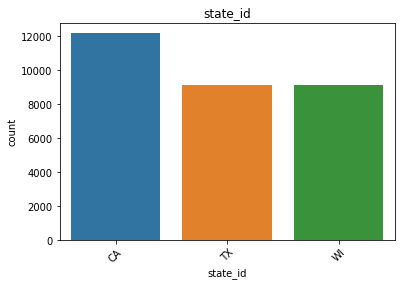

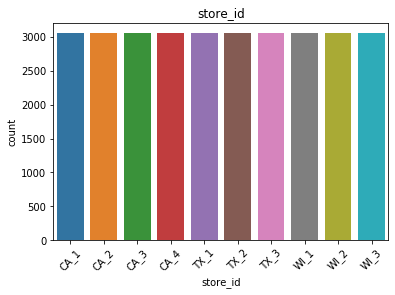

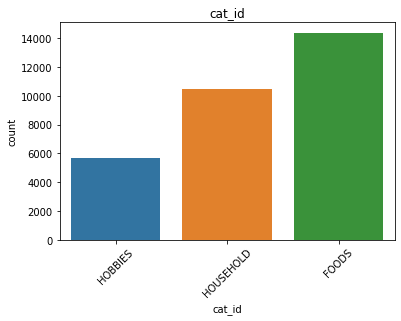

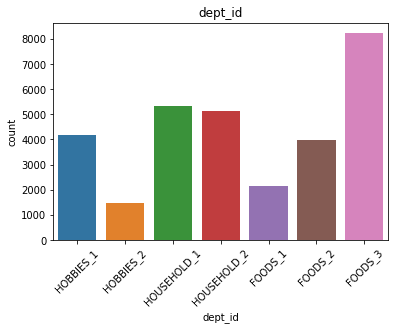

In [50]:
for i, var in enumerate(["state_id", "store_id", "cat_id", "dept_id"]):
    plt.figure()
    g = sns.countplot(validation[var])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_title(var)

In [51]:
validation.item_id.value_counts()

FOODS_1_218    10
FOODS_3_437    10
FOODS_3_552    10
FOODS_3_720    10
FOODS_2_155    10
               ..
FOODS_3_647    10
FOODS_3_140    10
FOODS_1_123    10
FOODS_1_075    10
FOODS_1_191    10
Name: item_id, Length: 3049, dtype: int64

In [55]:
validation = validation.sort_values(['item_id','store_id']).reset_index(drop=True)
validation

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,...,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,0,1,4,2,0,2,0,0,0,0,3,1,3,0,2,1,2,0,2,1,2,0,2,2,2,4,2,2,0,2,1,7,1,2,3,0,1,2,3,0,1,5,...,0,0,0,0,1,1,1,1,3,0,0,2,1,2,2,0,2,2,0,1,1,0,2,1,1,0,4,0,0,4,1,3,0,1,0,2,2,0,1,1,0,2,0,4,1,1,0,1,1,0
1,FOODS_1_001_CA_2_validation,FOODS_1_001,FOODS_1,FOODS,CA_2,CA,2,0,0,0,1,0,8,0,4,1,2,1,1,3,4,1,2,2,2,0,1,1,1,1,2,3,16,0,0,0,0,0,1,1,1,1,3,1,0,0,0,1,2,1,...,0,2,0,0,1,1,0,0,4,2,1,0,0,0,2,1,0,0,0,0,2,1,0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,2,0,1,0,14,0,1,1,4,0,0,4
2,FOODS_1_001_CA_3_validation,FOODS_1_001,FOODS_1,FOODS,CA_3,CA,1,2,1,1,1,2,0,1,1,1,0,0,3,3,2,7,1,2,4,0,1,1,3,2,0,0,0,0,6,6,1,1,0,0,4,3,6,5,1,0,3,1,1,1,...,1,0,0,1,0,0,0,0,2,0,0,0,1,2,4,2,0,1,1,1,12,0,0,0,1,0,0,1,0,0,0,1,0,0,4,2,1,0,0,0,0,0,13,0,0,0,0,0,1,0
3,FOODS_1_001_CA_4_validation,FOODS_1_001,FOODS_1,FOODS,CA_4,CA,0,1,1,1,1,1,0,0,0,0,0,0,1,2,1,0,1,0,0,1,0,2,0,1,0,1,1,0,1,0,0,1,1,1,0,0,1,2,2,2,1,0,0,1,...,0,4,0,0,1,2,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,1
4,FOODS_1_001_TX_1_validation,FOODS_1_001,FOODS_1,FOODS,TX_1,TX,0,1,1,0,0,0,0,0,2,1,0,0,0,1,0,0,0,0,0,0,0,0,1,2,0,0,2,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,1,0,...,3,1,0,0,1,0,0,2,0,1,1,1,0,1,2,1,0,1,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,TX_2,TX,0,1,0,0,0,0,1,1,0,0,0,1,1,1,1,3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0
30486,HOUSEHOLD_2_516_TX_3_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,TX_3,TX,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30487,HOUSEHOLD_2_516_WI_1_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_1,WI,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
30488,HOUSEHOLD_2_516_WI_2_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_2,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [61]:
def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i + 1) for i in range(drop_d)], axis=1)
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int16"))
    return df

validation = reshape_sales(validation, 1000)

In [62]:
validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1001,0.0
1,FOODS_1_001_CA_2,FOODS_1_001,FOODS_1,FOODS,CA_2,CA,1001,6.0
2,FOODS_1_001_CA_3,FOODS_1_001,FOODS_1,FOODS,CA_3,CA,1001,1.0
3,FOODS_1_001_CA_4,FOODS_1_001,FOODS_1,FOODS,CA_4,CA,1001,0.0
4,FOODS_1_001_TX_1,FOODS_1_001,FOODS_1,FOODS,TX_1,TX,1001,1.0


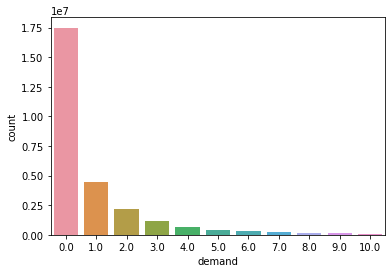

In [63]:
sns.countplot(validation["demand"][validation["demand"] <= 10]);

In [27]:
def prep_sales(df):
    df['lag_t28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    df['rolling_mean_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df['rolling_mean_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df['rolling_mean_t60'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df['rolling_mean_t90'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df['rolling_mean_t180'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df['rolling_std_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df['rolling_std_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())

    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df.rolling_mean_t180))]
    df = reduce_mem_usage(df)

    return df

validation = prep_sales(validation)

KeyError: 'Column not found: demand'

In [68]:
validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7
0,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1001,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FOODS_1_001_CA_2,FOODS_1_001,FOODS_1,FOODS,CA_2,CA,1001,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FOODS_1_001_CA_3,FOODS_1_001,FOODS_1,FOODS,CA_3,CA,1001,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FOODS_1_001_CA_4,FOODS_1_001,FOODS_1,FOODS,CA_4,CA,1001,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FOODS_1_001_TX_1,FOODS_1_001,FOODS_1,FOODS,TX_1,TX,1001,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
validation = validation.merge(calendar, how="left", on="d")
gc.collect()
validation.head()

KeyError: 'd'

In [10]:
main = validation.transpose().iloc[6:,:]
info = validation.transpose().iloc[0:6,:]

In [6]:
main.columns = info.loc['item_id'] + '_' + info.loc['store_id']
main.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,HOBBIES_1_026_CA_1,HOBBIES_1_027_CA_1,HOBBIES_1_028_CA_1,HOBBIES_1_029_CA_1,HOBBIES_1_030_CA_1,HOBBIES_1_031_CA_1,HOBBIES_1_032_CA_1,HOBBIES_1_033_CA_1,HOBBIES_1_034_CA_1,HOBBIES_1_035_CA_1,HOBBIES_1_036_CA_1,HOBBIES_1_037_CA_1,HOBBIES_1_038_CA_1,HOBBIES_1_039_CA_1,HOBBIES_1_040_CA_1,HOBBIES_1_041_CA_1,HOBBIES_1_042_CA_1,HOBBIES_1_043_CA_1,HOBBIES_1_044_CA_1,HOBBIES_1_045_CA_1,HOBBIES_1_046_CA_1,HOBBIES_1_047_CA_1,HOBBIES_1_048_CA_1,HOBBIES_1_049_CA_1,HOBBIES_1_050_CA_1,...,FOODS_3_778_WI_3,FOODS_3_779_WI_3,FOODS_3_780_WI_3,FOODS_3_781_WI_3,FOODS_3_782_WI_3,FOODS_3_783_WI_3,FOODS_3_784_WI_3,FOODS_3_785_WI_3,FOODS_3_786_WI_3,FOODS_3_787_WI_3,FOODS_3_788_WI_3,FOODS_3_789_WI_3,FOODS_3_790_WI_3,FOODS_3_791_WI_3,FOODS_3_792_WI_3,FOODS_3_793_WI_3,FOODS_3_794_WI_3,FOODS_3_795_WI_3,FOODS_3_796_WI_3,FOODS_3_797_WI_3,FOODS_3_798_WI_3,FOODS_3_799_WI_3,FOODS_3_800_WI_3,FOODS_3_801_WI_3,FOODS_3_802_WI_3,FOODS_3_803_WI_3,FOODS_3_804_WI_3,FOODS_3_805_WI_3,FOODS_3_806_WI_3,FOODS_3_807_WI_3,FOODS_3_808_WI_3,FOODS_3_809_WI_3,FOODS_3_810_WI_3,FOODS_3_811_WI_3,FOODS_3_812_WI_3,FOODS_3_813_WI_3,FOODS_3_814_WI_3,FOODS_3_815_WI_3,FOODS_3_816_WI_3,FOODS_3_817_WI_3,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
d_1,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,0,0,0,2,0,0,9,0,0,0,2,0,0,0,0,0,0,0,3,0,0,1,0,0,2,...,1,0,0,1,13,1,14,0,3,0,0,0,0,0,16,2,1,0,0,0,0,0,36,0,0,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0
d_2,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,3,0,0,2,0,0,0,...,2,0,0,2,7,1,7,0,5,0,0,0,0,0,12,6,0,0,0,0,0,0,39,0,0,0,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0
d_3,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,5,0,0,0,0,0,1,0,0,0,0,0,2,0,0,3,0,0,1,...,1,0,0,0,7,1,5,0,3,0,0,0,0,0,11,1,1,0,0,0,0,0,34,0,0,0,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0
d_4,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,21,3,13,0,0,0,0,0,0,0,11,3,1,0,0,0,0,0,42,0,0,0,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0
d_5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,10,0,10,0,3,0,0,0,0,0,6,5,0,0,0,0,0,0,29,0,0,0,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0


In [29]:
info.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,30440,30441,30442,30443,30444,30445,30446,30447,30448,30449,30450,30451,30452,30453,30454,30455,30456,30457,30458,30459,30460,30461,30462,30463,30464,30465,30466,30467,30468,30469,30470,30471,30472,30473,30474,30475,30476,30477,30478,30479,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
id,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,HOBBIES_1_011_CA_1_validation,HOBBIES_1_012_CA_1_validation,HOBBIES_1_013_CA_1_validation,HOBBIES_1_014_CA_1_validation,HOBBIES_1_015_CA_1_validation,HOBBIES_1_016_CA_1_validation,HOBBIES_1_017_CA_1_validation,HOBBIES_1_018_CA_1_validation,HOBBIES_1_019_CA_1_validation,HOBBIES_1_020_CA_1_validation,HOBBIES_1_021_CA_1_validation,HOBBIES_1_022_CA_1_validation,HOBBIES_1_023_CA_1_validation,HOBBIES_1_024_CA_1_validation,HOBBIES_1_025_CA_1_validation,HOBBIES_1_026_CA_1_validation,HOBBIES_1_027_CA_1_validation,HOBBIES_1_028_CA_1_validation,HOBBIES_1_029_CA_1_validation,HOBBIES_1_030_CA_1_validation,HOBBIES_1_031_CA_1_validation,HOBBIES_1_032_CA_1_validation,HOBBIES_1_033_CA_1_validation,HOBBIES_1_034_CA_1_validation,HOBBIES_1_035_CA_1_validation,HOBBIES_1_036_CA_1_validation,HOBBIES_1_037_CA_1_validation,HOBBIES_1_038_CA_1_validation,HOBBIES_1_039_CA_1_validation,HOBBIES_1_040_CA_1_validation,HOBBIES_1_041_CA_1_validation,HOBBIES_1_042_CA_1_validation,HOBBIES_1_043_CA_1_validation,HOBBIES_1_044_CA_1_validation,HOBBIES_1_045_CA_1_validation,HOBBIES_1_046_CA_1_validation,HOBBIES_1_047_CA_1_validation,HOBBIES_1_048_CA_1_validation,HOBBIES_1_049_CA_1_validation,HOBBIES_1_050_CA_1_validation,...,FOODS_3_778_WI_3_validation,FOODS_3_779_WI_3_validation,FOODS_3_780_WI_3_validation,FOODS_3_781_WI_3_validation,FOODS_3_782_WI_3_validation,FOODS_3_783_WI_3_validation,FOODS_3_784_WI_3_validation,FOODS_3_785_WI_3_validation,FOODS_3_786_WI_3_validation,FOODS_3_787_WI_3_validation,FOODS_3_788_WI_3_validation,FOODS_3_789_WI_3_validation,FOODS_3_790_WI_3_validation,FOODS_3_791_WI_3_validation,FOODS_3_792_WI_3_validation,FOODS_3_793_WI_3_validation,FOODS_3_794_WI_3_validation,FOODS_3_795_WI_3_validation,FOODS_3_796_WI_3_validation,FOODS_3_797_WI_3_validation,FOODS_3_798_WI_3_validation,FOODS_3_799_WI_3_validation,FOODS_3_800_WI_3_validation,FOODS_3_801_WI_3_validation,FOODS_3_802_WI_3_validation,FOODS_3_803_WI_3_validation,FOODS_3_804_WI_3_validation,FOODS_3_805_WI_3_validation,FOODS_3_806_WI_3_validation,FOODS_3_807_WI_3_validation,FOODS_3_808_WI_3_validation,FOODS_3_809_WI_3_validation,FOODS_3_810_WI_3_validation,FOODS_3_811_WI_3_validation,FOODS_3_812_WI_3_validation,FOODS_3_813_WI_3_validation,FOODS_3_814_WI_3_validation,FOODS_3_815_WI_3_validation,FOODS_3_816_WI_3_validation,FOODS_3_817_WI_3_validation,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
item_id,HOBBIES_1_001,HOBBIES_1_002,HOBBIES_1_003,HOBBIES_1_004,HOBBIES_1_005,HOBBIES_1_006,HOBBIES_1_007,HOBBIES_1_008,HOBBIES_1_009,HOBBIES_1_010,HOBBIES_1_011,HOBBIES_1_012,HOBBIES_1_013,HOBBIES_1_014,HOBBIES_1_015,HOBBIES_1_016,HOBBIES_1_017,HOBBIES_1_018,HOBBIES_1_019,HOBBIES_1_020,HOBBIES_1_021,HOBBIES_1_022,HOBBIES_1_023,HOBBIES_1_024,HOBBIES_1_025,HOBBIES_1_026,HOBBIES_1_027,HOBBIES_1_028,HOBBIES_1_029,HOBBIES_1_030,HOBBIES_1_031,HOBBIES_1_032,HOBBIES_1_033,HOBBIES_1_034,HOBBIES_1_035,HOBBIES_1_036,HOBBIES_1_037,HOBBIES_1_038,HOBBIES_1_039,HOBBIES_1_040,HOBBIES_1_041,HOBBIES_1_042,HOBBIES_1_043,HOBBIES_1_044,HOBBIES_1_045,HOBBIES_1_

In [30]:
# Only days that are available on both csv's are considered. dfcal is a subset of the calendar dataframes
main1 = pd.merge(main, calendar,left_index=True, right_on='d')
main1.head(5)
dfcal = main1[['date','wm_yr_wk','weekday','wday','month','year','d','event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']]

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

In [13]:
# Extracts price information for the desired format

iteration = 0
main1price = pd.DataFrame()
for item_store_i in range(30489):
    item_id_now = info.loc['item_id'][item_store_i]
    store_id_now = info.loc['store_id'][item_store_i]
    dfcal['item_id'] = item_id_now
    dfcal['store_id'] = store_id_now
    dfcalprice = pd.merge(dfcal, sell_prices, left_on = ['wm_yr_wk','item_id','store_id'], right_on= ['wm_yr_wk','item_id','store_id']) 
# main1price[item_store_i] = dfcalprice['sell_price']
    main1price.insert(item_store_i, (item_id_now +'_' + store_id_now) , dfcalprice['sell_price'])
    iteration += 1
    print((iteration/30489)*100)

0.0032798714290399817
0.006559742858079963
0.009839614287119944
0.013119485716159927


KeyboardInterrupt: 

In [44]:
validation = validation.merge(sell_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
validation.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
validation.head()

KeyError: 'wm_yr_wk'

In [45]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [46]:
del sell_prices

In [47]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [50]:
from sklearn.preprocessing import LabelEncoder

cat_id_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id"]
cat_cols = cat_id_cols + ["wday", "month", "year", "event_name_1", 
                          "event_type_1", "event_name_2", "event_type_2"]

# In loop to minimize memory use
for i, v in tqdm(enumerate(cat_id_cols)):
    validation[v] = OrdinalEncoder(dtype="int").fit_transform(validation[[v]])

validation = reduce_mem_usage(validation)
validation.head()
gc.collect()

NameError: name 'OrdinalEncoder' is not defined

In [51]:
num_cols = ["sell_prices", "sell_price_rel_diff", "sell_price_roll_sd7", "sell_price_cumrel",
            "lag_t28", "rolling_mean_t7", "rolling_mean_t30", "rolling_mean_t60", 
            "rolling_mean_t90", "rolling_mean_t180", "rolling_std_t7", "rolling_std_t30"]
bool_cols = ["snap_CA", "snap_TX", "snap_WI"]
dense_cols = num_cols + bool_cols

# Need to do column by column due to memory constraints
for i, v in tqdm(enumerate(num_cols)):
    validation[v] = validation[v].fillna(sales[v].median())
    
validation.head()

KeyError: 'sell_prices'

In [52]:
test = validation[validation.d >= 1914]
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))
test.head()
gc.collect()

AttributeError: 'DataFrame' object has no attribute 'd'

In [ ]:
# Merges column information to the price dataframe
main1price2 = pd.merge(main1price, calendar, right_index=True, left_index=True)

In [ ]:
#Handles the last column that we forgot :)

dfcal['item_id']= 'HOUSEHOLD_2_516'
dfcal['store_id'] = 'WI_3'
df_eksik_sp = sell_prices[(sell_prices['item_id']=='HOUSEHOLD_2_516') & (sell_prices['store_id']=='WI_3')]
dfx = pd.merge(dfcal, df_eksik_sp, left_on = ['wm_yr_wk','item_id','store_id'], right_on= ['wm_yr_wk','item_id','store_id']) 
main1price3 = main1price2.copy()
main1price3.insert(30489,'HOUSEHOLD_2_516_WI_3' ,dfx['sell_price'])

In [ ]:
main1.to_csv('main.csv', index=False)
main1price3.to_csv('prices.csv',index=False)
main1price3.to_pickle('main1price3')
main1.to_pickle('main1')

In [ ]:
main1.shape, main1price3.shape